# Problem 6

In [1]:
import time
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms

import matplotlib.pyplot as plt

Following is Alexnet constructed in source code.

In [2]:
class AlexNet(nn.Module):
    def __init__(self, num_class=10):
        super(AlexNet, self).__init__()

        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=4),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, kernel_size=3),
            nn.ReLU(inplace=True)
        )
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.conv_layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.fc_layer1 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(6400, 800),
            nn.ReLU(inplace=True),
            nn.Linear(800, 10)
        )

    def forward(self, x):
        output = self.conv_layer1(x)
        output = self.conv_layer2(output)
        output = self.conv_layer3(output)
        output = torch.flatten(output, 1)
        output = self.fc_layer1(output)
        return output

Define hyperparameters and load data. To reduce time, we choose random 6000 data among whole set.  
We label new value randomly.

In [3]:
learning_rate = 0.1
batch_size = 64
epochs = 150

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet().to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

chosen_6000_index = np.random.choice(60000,6000)
train_dataset = datasets.MNIST(root='./mnist_data/',
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)
train_dataset.data = train_dataset.data[chosen_6000_index]
train_dataset.targets = np.random.randint(0, 10, size=(6000,))
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

Next we train the model.  
In each epoch, 6000 data is trained. To trace train loss, we save all loss for each epoch and avarage.

In [4]:
tick = time.time()
losses = []
for epoch in range(150):
    epoch_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        loss = loss_function(model(images), labels)
        loss.backward()

        optimizer.step()
        
        epoch_loss += torch.sum(loss)
    
    losses.append(epoch_loss/6000)
    epoch_loss = 0
        
    if (epoch+1)%10 == 0: print(f"Epoch {epoch - 8} ~ {epoch + 1} / {epochs}")

tock = time.time()
print(f"Total training time: {tock - tick}")

Epoch 1 ~ 10 / 150
Epoch 11 ~ 20 / 150
Epoch 21 ~ 30 / 150
Epoch 31 ~ 40 / 150
Epoch 41 ~ 50 / 150
Epoch 51 ~ 60 / 150
Epoch 61 ~ 70 / 150
Epoch 71 ~ 80 / 150
Epoch 81 ~ 90 / 150
Epoch 91 ~ 100 / 150
Epoch 101 ~ 110 / 150
Epoch 111 ~ 120 / 150
Epoch 121 ~ 130 / 150
Epoch 131 ~ 140 / 150
Epoch 141 ~ 150 / 150
Total training time: 383.67131090164185


As you can see, our model trains well.

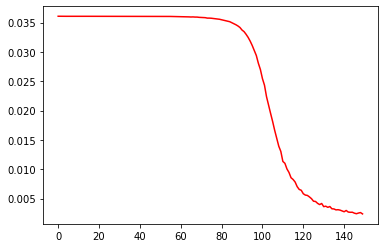

In [6]:
x = np.arange(150)
losses_cpu = [loss.cpu().detach().numpy() for loss in losses]

plt.plot(x, losses_cpu, 'r')